In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from postprocess_utils import *
import pandas as pd
import sqlalchemy

In [3]:
from utils import gen_data, gen_covariance, sparsify_beta, gen_beta2

In [4]:
root_dir = '/media/akumar/Data/nse'

In [5]:
import pickle

In [6]:
with open('alpha_datalist.dat', 'rb') as f:
    alpha_datalist = pickle.load(f)

In [7]:
with open('alpha_datalist_uoi.dat', 'rb') as f:
    alpha_datalist_uoi = pickle.load(f)

In [8]:
alpha_datalist = pd.concat([pd.DataFrame(alpha_datalist), pd.DataFrame(alpha_datalist_uoi)])

### Simoid Fitting

In [ ]:
# Fit sigmoids to:

# (1) each algorithm, each selection method, each sparsity
# (2) the same, but separate by betawidth
# (3) combine the different SNR together

In [9]:
list(alpha_datalist.keys())

['df_name', 'betawidth', 'sparsity', 'alpha', 'sa', 'selection_method']

In [10]:
algorithms = np.unique(alpha_datalist['df_name'].values)
selection_methods = np.unique(alpha_datalist['selection_method'].values)
sparsity = np.unique(alpha_datalist['sparsity'].values)

In [11]:
from sigmoid import Sigmoid

In [ ]:
# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

marker_type = ['^', 'o', 's']

In [43]:
# Calculate all sigmoid coefficients and store in dataframe

# Eventually 
np_ratio = 4
kappa = 5

sigmoid_df = []

for k, s in enumerate(sparsity):
    for i, algorithm in enumerate(algorithms):
        for j, selection_method in enumerate(selection_methods):
            adl = apply_df_filters(alpha_datalist, df_name=algorithm,
                       sparsity=s, selection_method=selection_method)            
            # Take sa vs. log alpha and fit a sigmoid to it
            sigmoid = Sigmoid()
            alpha_mask = np.ma.log(adl['alpha'].values[0])
            mask = np.invert(alpha_mask.mask)
            alpha_ = np.log(adl['alpha'].values[0][mask])
            sa_ = adl['sa'].values[0][mask]
            try:
                sigmoid.fit(alpha_, sa_)
                sigmoid_df.append({'df':algorithm, 'sparsity':s, 'selection_method': selection_method,
                   'kappa' : 5, 'np_ratio': 4, 'coefs': sigmoid.coef_, 'cov' : sigmoid.coef_cov})
            except:
                sigmoid_df.append({'df':algorithm, 'sparsity':s, 'selection_method': selection_method,
                                   'kappa' : 5, 'np_ratio': 4, 'coefs': np.nan, 'cov' : np.nan})

In [17]:
count

34

In [16]:
# How many nans are there?
count = 0
for elem in sigmoid_df:
    if np.all(np.isnan(elem['coefs'])):
        count +=1

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


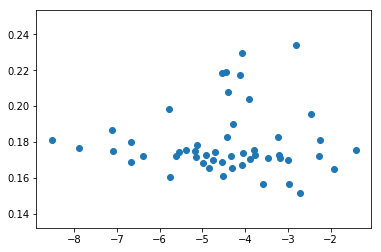

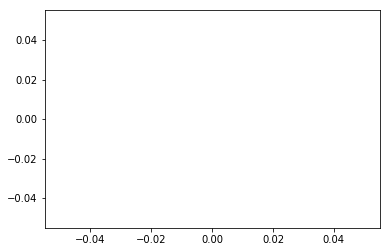

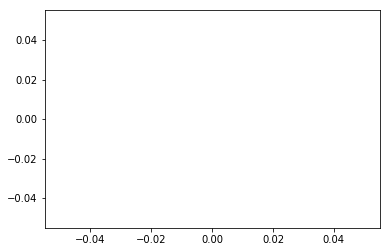

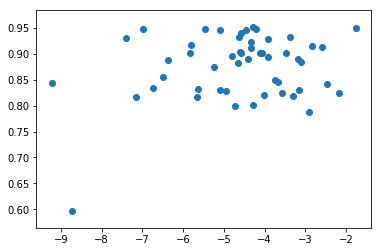

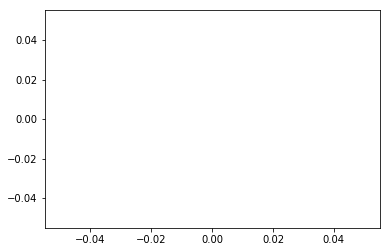

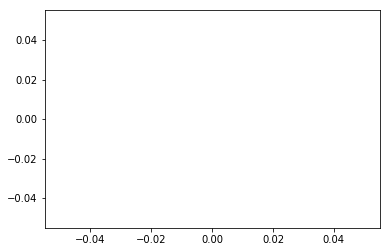

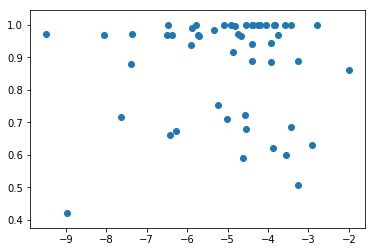

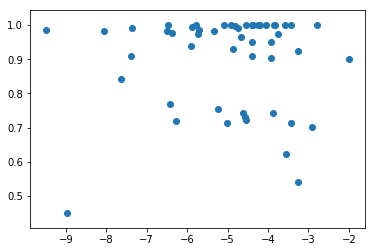

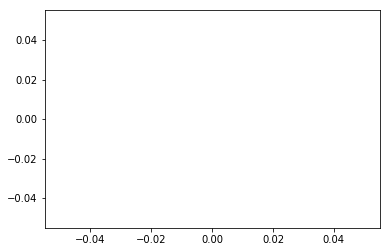

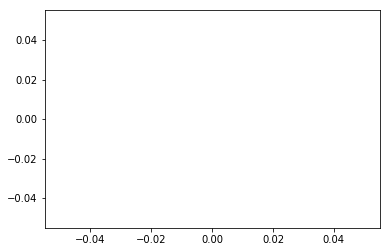

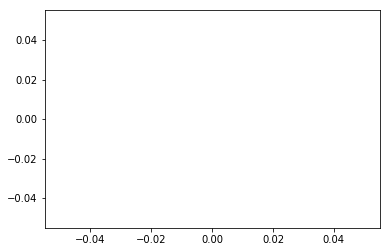

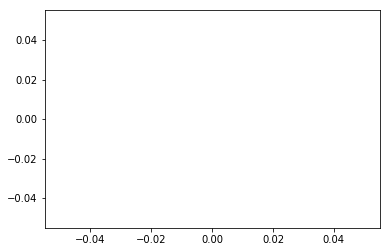

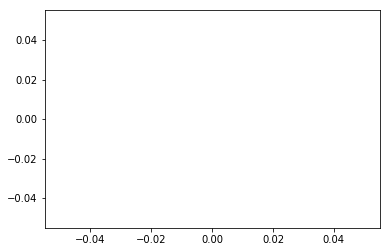

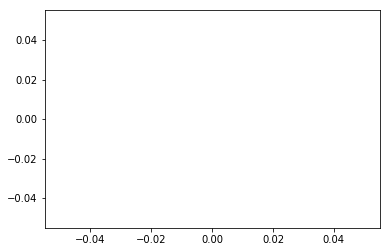

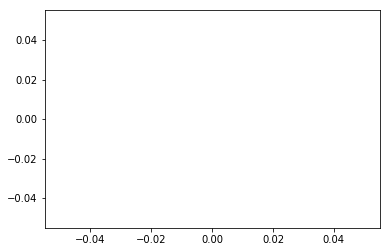

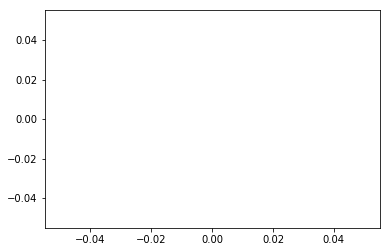

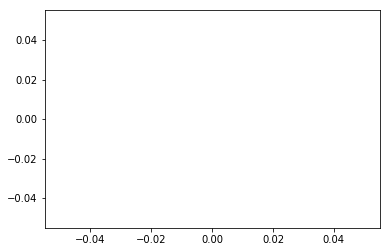

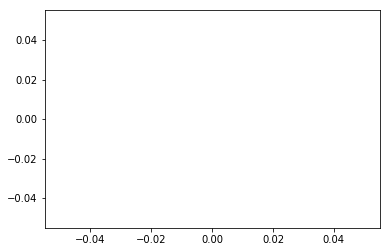

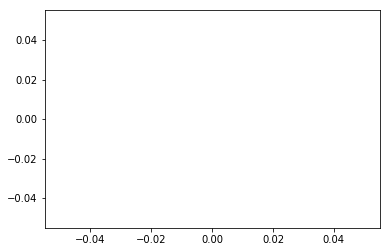

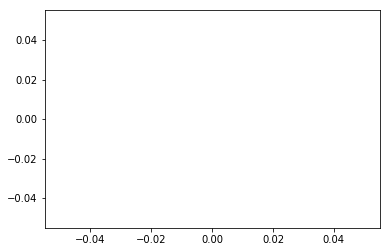

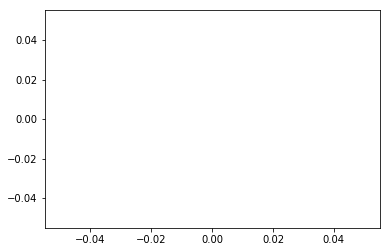

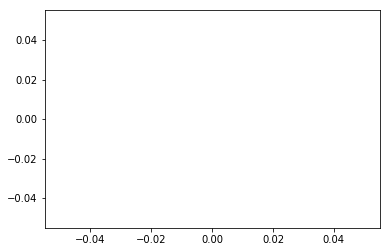

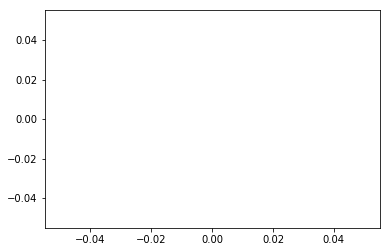

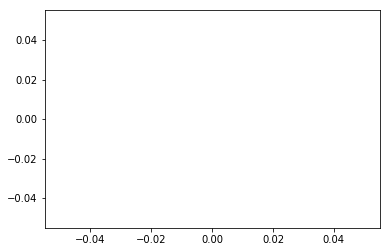

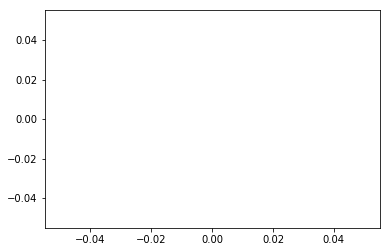

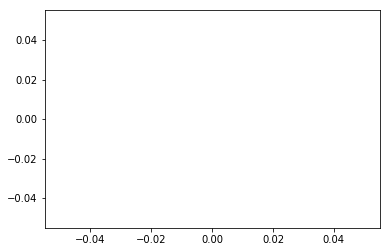

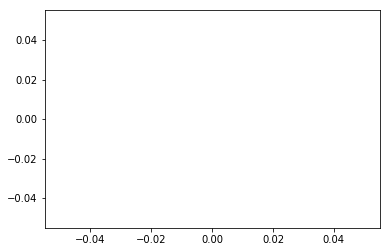

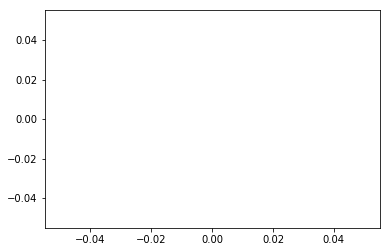

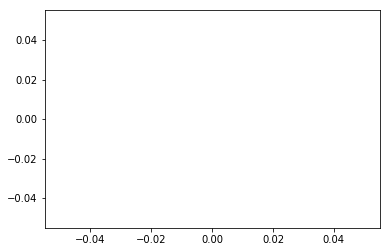

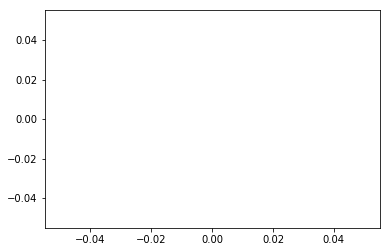

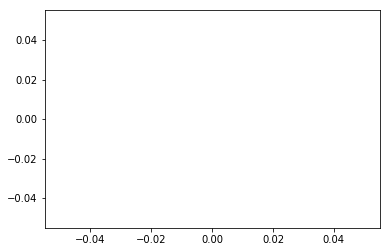

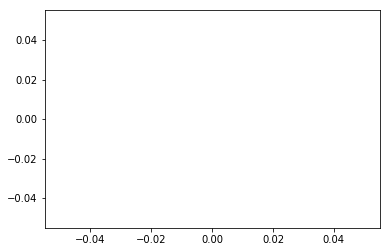

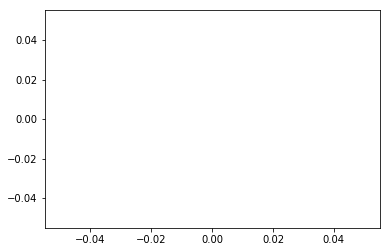

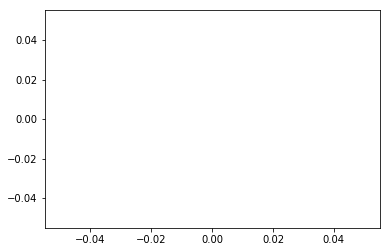

In [23]:
# What to do about nans?
for i, elem in enumerate(sigmoid_df):
    if np.all(np.isnan(elem['coefs'])):
        # grab the raw alpha/sa data:
        adl = apply_df_filters(alpha_datalist, df_name=elem['df'],
              sparsity=elem['sparsity'], selection_method=elem['selection_method'])            
        
        # Plot alpha and sa and save away
        alpha_mask = np.ma.log(adl['alpha'].values[0])
        mask = np.invert(alpha_mask.mask)
        alpha_ = np.log(adl['alpha'].values[0][mask])
        sa_ = adl['sa'].values[0][mask]
        fig, ax = plt.subplots()        
        ax.scatter(alpha_, sa_)
        fig.savefig('abberation%d.png' % i)

In [ ]:
# Other summary metrics: 

# 'Expected' FNR/FPR and variance around it
# Use the statistics from above and sigmoid fits to construct decision trees about
# what algorithm to use/selection method to use considering 
# alpha, (eta?), SNR, n/p, density

# Come up with concrete 'Best of best' statistics

# Contrast with theory, when do the theoretical results seem helpful?

# Investigate 
# (1) aberrations in point clouds 
# (2) wtf is going on with eta calculation

In [37]:
betawidth = np.unique(alpha_datalist['betawidth'].values)

In [44]:
# Separate by betawidth
np_ratio = 4
kappa = 5

sigmoid_df_bw = []

for k, s in enumerate(sparsity):
    for i, algorithm in enumerate(algorithms):
        for j, selection_method in enumerate(selection_methods):
            for l, bw in enumerate(betawidth):
                adl = apply_df_filters(alpha_datalist, df_name=algorithm,
                           sparsity=s, selection_method=selection_method,
                            betawidth=bw)            
                if adl.shape[0] == 0:
                    pdb.set_trace()
                # Take sa vs. log alpha and fit a sigmoid to it
                sigmoid = Sigmoid()
                alpha_mask = np.ma.log(adl['alpha'].values[0])
                mask = np.invert(alpha_mask.mask)
                alpha_ = np.log(adl['alpha'].values[0][mask])
                sa_ = adl['sa'].values[0][mask]
                try:
                    sigmoid.fit(alpha_, sa_)
                    sigmoid_df_bw.append({'df':algorithm, 'sparsity':s, 'selection_method': selection_method,
                       'kappa' : 5, 'np_ratio': 4, 'coefs': sigmoid.coef_, 'cov' : sigmoid.coef_cov,
                       'betawidth': bw})
                except:
                    sigmoid_df_bw.append({'df':algorithm, 'sparsity':s, 'selection_method': selection_method,
                                       'kappa' : 5, 'np_ratio': 4, 'coefs': np.nan, 'cov' : np.nan,
                                       'betawidth' : bw})

In [34]:
alpha_datalist.loc[alpha_datalist['betawidth'] == 0.1].shape

(600, 6)

In [41]:
# How many nans are there?
count = 0
for elem in sigmoid_df:
    if np.all(np.isnan(elem['coefs'])):
        count +=1
print(count)

100
